## The Data



**Monthly sales data -- 2005 to 2018**

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sales_data = pd.read_csv('monthly-sales.csv',index_col='Month')

In [4]:
sales_data.head()

,Sales
Month,
1/1/2005 1:00,589
2/1/2005 1:00,561
3/1/2005 1:00,640
4/1/2005 1:00,656
5/1/2005 1:00,727


In [5]:
sales_data.index = pd.to_datetime(sales_data.index)

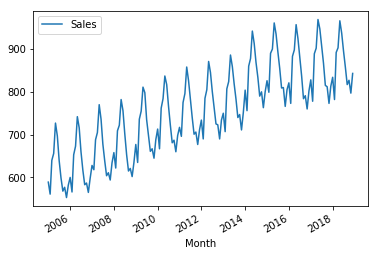

In [6]:
sales_data.plot()

___

### Train-Test Split



In [7]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 2005-01-01 01:00:00 to 2018-12-01 01:00:00
Data columns (total 1 columns):
Sales    168 non-null int64
dtypes: int64(1)
memory usage: 2.6 KB


In [8]:
train_set = sales_data[:-12] # All data except last year for tranining

In [9]:
test_set = sales_data[-12:]   # Last year - 12 months - for testing

### Scaling



In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
min_max_scaler = MinMaxScaler()

In [12]:
train_scale = min_max_scaler.fit_transform(train_set * 1.0)

In [13]:
test_scale = min_max_scaler.transform(test_set * 1.0)

## Batch Function



In [14]:
def next_batch(training_data,batch_size,steps):
    """
    INPUT: Data, Batch Size, Time Steps per batch (number of time periods)
    OUTPUT: A tuple of y time series results. y[:,:-1] and y[:,1:]
    """
    
    # STEP 1: Use np.random.randint to set a random starting point index for the batch.
    # Remember that each batch needs have the same number of steps in it.
    # This means you should limit the starting point to len(data)-steps
    
    # STEP 2: Now that you have a starting index you'll need to index the data from
    # the random start to random start + steps. Then reshape this data to be (1,steps)
    
    # STEP 3: Return the batches. You'll have two batches to return y[:,:-1] and y[:,1:]
    # You'll need to reshape these into tensors for the RNN. Depending on your indexing it
    # will be either .reshape(-1,steps-1,1) or .reshape(-1,steps,1)
    
    # Shape is 3 - dimension because of [None, time_steps, n_inputs] -> None is the batch_size.

In [15]:
def next_batch(training_data,batch_size,steps):    
    
    # Grab a random starting point for each batch
    # Make sure it is within 0 and length - steps, because we need to have data as many as defined in the steps.
    rand_start = np.random.randint(0,len(training_data)-steps) 

    # Create Y data for time series in the batches
    # Get the data from the rand_start to next data point upto steps + 1.
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)

    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

## RNN Model

In [16]:
import tensorflow as tf

In [17]:
# Just one feature, the time series
num_inputs = 1
# Num of steps in each batch (x(t-12))
num_time_steps = 12
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1

## You can also try increasing iterations, but decreasing learning rate
# learning rate you can play with this
learning_rate = 0.03 
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 1000
# Size of the batch of data
batch_size = 1

** Create Placeholders for X and y. (You can change the variable names if you want). The shape for these placeholders should be [None,num_time_steps-1,num_inputs] and [None, num_time_steps-1, num_outputs] The reason we use num_time_steps-1 is because each of these will be one step shorter than the original time steps size, because we are training the RNN network to predict one point into the future based on the input sequence. **

In [18]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

**Why is OutputProjectionWrapper required?**

At each time step we now have an output vector of size 100 (num_neurons). But what we actually want is a single output value at each time step. The simplest solution is to wrap the cell in an OutputProjectionWrapper. A cell

The OutputProjectionWrapper adds a fully connected layer of linear neurons (i.e., without any activation function) on top of each output (but it does not affect the cell state). 
All these fully connected layers share the same (trainable) weights and bias terms.

In [19]:
# Also play around with GRUCell
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs) 

** Now pass in the cells variable into tf.nn.dynamic_rnn, along with your first placeholder (X)**

In [20]:
# Outputs gives all outputs - y0, y1, y2,...yn
# states gives the final state --- yn

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### Loss Function and Optimizer

In [21]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

** Initialize the global variables **

In [22]:
init = tf.global_variables_initializer()

** Create an instance of tf.train.Saver() **

In [23]:
saver = tf.train.Saver()

### Session

**Run a tf.Session that trains on the batches created by your next_batch function. Also add an a loss evaluation for every 100 training iterations. Remember to save your model after you are done training.**

In [24]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [26]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scale,batch_size,num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./ex_time_series_model")

0 	MSE: 0.70249915
100 	MSE: 0.009485374
200 	MSE: 0.013846288
300 	MSE: 0.010171897
400 	MSE: 0.008798658
500 	MSE: 0.0039590797
600 	MSE: 0.011601345
700 	MSE: 0.0062726806
800 	MSE: 0.006484039
900 	MSE: 0.0069372444


In [33]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./ex_time_series_model")

0 	MSE: 0.0628359
100 	MSE: 0.00854151
200 	MSE: 0.00699567
300 	MSE: 0.0156167
400 	MSE: 0.00777238
500 	MSE: 0.00864684
600 	MSE: 0.0159645
700 	MSE: 0.00656524
800 	MSE: 0.0076439
900 	MSE: 0.006401
1000 	MSE: 0.00369383
1100 	MSE: 0.00988994
1200 	MSE: 0.00803645
1300 	MSE: 0.00575964
1400 	MSE: 0.0151093
1500 	MSE: 0.00752775
1600 	MSE: 0.00542804
1700 	MSE: 0.00162975
1800 	MSE: 0.00230503
1900 	MSE: 0.00416592
2000 	MSE: 0.00369024
2100 	MSE: 0.00397327
2200 	MSE: 0.00235241
2300 	MSE: 0.00472639
2400 	MSE: 0.00418429
2500 	MSE: 0.00693244
2600 	MSE: 0.00375631
2700 	MSE: 0.00236074
2800 	MSE: 0.00268888
2900 	MSE: 0.00708326
3000 	MSE: 0.00418036
3100 	MSE: 0.00486205
3200 	MSE: 0.00659863
3300 	MSE: 0.00621194
3400 	MSE: 0.00150676
3500 	MSE: 0.0050875
3600 	MSE: 0.00395521
3700 	MSE: 0.00200348
3800 	MSE: 0.00386259
3900 	MSE: 0.00360108


______

## Predicting Future (Test Data)

** Show the test_set (the last 12 months of your original complete data set) **

In [27]:
test_set

,Sales
Month,
2018-01-01 01:00:00,834
2018-02-01 01:00:00,782
2018-03-01 01:00:00,892
2018-04-01 01:00:00,903
2018-05-01 01:00:00,966
2018-06-01 01:00:00,937
2018-07-01 01:00:00,896
2018-08-01 01:00:00,858
2018-09-01 01:00:00,817


**Now we want to attempt to predict these 12 months of data, using only the training data we had. To do this we will feed in a seed training_instance of the last 12 months of the training_set of data to predict 12 months into the future. Then we will be able to compare our generated 12 months to our actual true historical values from the test set!**

In [ ]:
# Since we have trained to predict only 1 time step ahead, we will have to use the predicted output to 
# get the next predictd output.

# Ideally, you might want the model to predict 12 time periods ahead.

In [28]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./ex_time_series_model")

    # Create a numpy array for your genreative seed from the last 12 months of the 
    # training set data.
    train_seed = list(train_scale[-12:])
    
    ## Now create a for loop that 
    for iteration in range(12):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./ex_time_series_model


** Show the result of the predictions. **

In [29]:
train_seed

[array([0.66105769]),
 array([0.54086538]),
 array([0.80769231]),
 array([0.83894231]),
 array([1.]),
 array([0.94711538]),
 array([0.85336538]),
 array([0.75480769]),
 array([0.62980769]),
 array([0.62259615]),
 array([0.52884615]),
 array([0.625]),
 0.62029254,
 0.6853094,
 0.7238662,
 0.7645204,
 0.7852402,
 0.76930857,
 0.7316561,
 0.69776964,
 0.68000233,
 0.6805943,
 0.69778156,
 0.7284974]

** Grab the portion of the results that are the generated values and apply inverse_transform on them to turn them back into milk production value units (lbs per cow). Also reshape the results to be (12,1) so we can easily add them to the test_set dataframe.**

In [31]:
results = min_max_scaler.inverse_transform(np.array(train_seed[12:]).reshape(12,1))

In [33]:
test_set['Generated'] = results

C:\tools\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
test_set

,Sales,Generated
Month,,
2018-01-01 01:00:00,834,811.041687
2018-02-01 01:00:00,782,838.088684
2018-03-01 01:00:00,892,854.128296
2018-04-01 01:00:00,903,871.040466
2018-05-01 01:00:00,966,879.659912
2018-06-01 01:00:00,937,873.032349
2018-07-01 01:00:00,896,857.368896
2018-08-01 01:00:00,858,843.272156
2018-09-01 01:00:00,817,835.880981


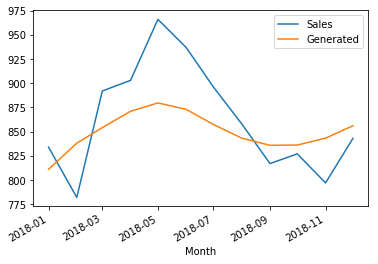

In [35]:
test_set.plot()